In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, confusion_matrix, make_scorer, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn import tree

from myFunctions import print_metrics_test, plot_feature_importances

import warnings
warnings.filterwarnings('ignore')

# Import Cleaned Data

In [102]:
data = pd.read_csv('csv_files/processed_data.csv',index_col=0)

In [103]:
# removing point features
data = data.drop(['PTS_home','PTS_away'],axis=1)
data.head()

,SEASON,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,...,BLK_home,PF_home,STL_home,TO_home,BLK_away,PF_away,STL_away,TO_away,HOME_TEAM,VISITOR_TEAM
0,2019,0.35400,0.90000,0.22900,22.00000,47.00000,0.40200,0.76200,0.22600,20.00000,...,8.00000,18.00000,7.00000,10.00000,6.00000,11.00000,7.00000,16.00000,Hornets,Bucks
1,2019,0.37200,0.83300,0.35900,24.00000,39.00000,0.50600,0.75000,0.27800,26.00000,...,3.00000,22.00000,6.00000,13.00000,8.00000,22.00000,8.00000,15.00000,Hornets,Bucks
2,2013,0.43400,0.75000,0.58800,30.00000,43.00000,0.43300,0.94100,0.35700,29.00000,...,7.00000,17.00000,2.00000,8.00000,8.00000,23.00000,8.00000,12.00000,Hornets,Bucks
3,2013,0.44300,0.61300,0.20000,20.00000,54.00000,0.33300,0.75000,0.29400,17.00000,...,4.00000,17.00000,5.00000,17.00000,9.00000,22.00000,10.00000,9.00000,Hornets,Bucks
4,2012,0.46300,0.70800,0.44400,23.00000,52.00000,0.39100,0.66700,0.31000,23.00000,...,5.00000,18.00000,6.00000,14.00000,3.00000,20.00000,6.00000,12.00000,Hornets,Bucks


# Split Train and Test Data

In [104]:
filtered_seasons = [2014,2015,2016,2017,2018]

# split data into training(2014 - 2018 games) and test data(2019 games)
season_2014_2018 = data[data['SEASON'].isin(filtered_seasons)].drop('SEASON',axis=1)
season_2019 = data[data['SEASON'] == 2019].drop('SEASON',axis=1)

In [105]:
# split data into features and target for training data
X_train = season_2014_2018.drop('HOME_TEAM_WINS',axis=1).drop(['HOME_TEAM','VISITOR_TEAM'],axis=1)
y_train = season_2014_2018['HOME_TEAM_WINS']

In [106]:
# split data into features and target for test data
X_test = season_2019.drop('HOME_TEAM_WINS',axis=1).drop(['HOME_TEAM','VISITOR_TEAM'],axis=1)
y_test = season_2019['HOME_TEAM_WINS']

In [107]:
X_test.head()

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,BLK_home,PF_home,STL_home,TO_home,BLK_away,PF_away,STL_away,TO_away
0,0.35400,0.90000,0.22900,22.00000,47.00000,0.40200,0.76200,0.22600,20.00000,61.00000,8.00000,18.00000,7.00000,10.00000,6.00000,11.00000,7.00000,16.00000
1,0.37200,0.83300,0.35900,24.00000,39.00000,0.50600,0.75000,0.27800,26.00000,53.00000,3.00000,22.00000,6.00000,13.00000,8.00000,22.00000,8.00000,15.00000
50,0.35900,0.86400,0.30200,20.00000,47.00000,0.53800,0.66700,0.35900,24.00000,57.00000,4.00000,23.00000,12.00000,15.00000,6.00000,20.00000,8.00000,17.00000
70,0.41800,0.80600,0.41900,21.00000,54.00000,0.42900,0.79400,0.36700,18.00000,54.00000,3.00000,28.00000,4.00000,19.00000,11.00000,28.00000,7.00000,15.00000
94,0.45800,0.80000,0.28600,26.00000,45.00000,0.49500,0.76700,0.25600,29.00000,52.00000,3.00000,24.00000,8.00000,16.00000,4.00000,12.00000,11.00000,11.00000


In [108]:
y_test.head()

0     0
1     0
50    0
70    0
94    0
Name: HOME_TEAM_WINS, dtype: int64

# Descriptive Statistics

## Home vs Away Stats

In [109]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
season_2014_2018.describe()

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,BLK_home,PF_home,STL_home,TO_home,BLK_away,PF_away,STL_away,TO_away
count,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000,6999.00000
mean,0.46044,0.76260,0.35732,23.39434,44.45106,0.44994,0.76081,0.34901,22.23575,43.30133,0.58408,5.05501,20.22589,7.76954,13.66867,4.65609,20.82626,7.77425,13.86612
std,0.05484,0.10237,0.09668,5.20370,6.50199,0.05416,0.10503,0.09494,5.08306,6.46811,0.49291,2.59062,4.42375,2.98111,3.96315,2.42796,4.51568,2.96269,4.02037
min,0.28200,0.14300,0.00000,9.00000,22.00000,0.27100,0.17600,0.00000,6.00000,20.00000,0.00000,0.00000,8.00000,0.00000,2.00000,0.00000,7.00000,0.00000,3.00000
25%,0.42200,0.70000,0.29400,20.00000,40.00000,0.41300,0.69600,0.28600,19.00000,39.00000,0.00000,3.00000,17.00000,6.00000,11.00000,3.00000,18.00000,6.00000,11.00000
50%,0.45900,0.76900,0.35500,23.00000,44.00000,0.44900,0.76700,0.34800,22.00000,43.00000,1.00000,5.00000,20.00000,8.00000,13.00000,4.00000,21.00000,8.00000,14.00000
75%,0.50000,0.83300,0.41900,27.00000,49.00000,0.48600,0.83300,0.41200,26.00000,47.00000,1.00000,7.00000,23.00000,10.00000,16.00000,6.00000,24.00000,10.00000,16.00000
max,0.68400,1.00000,0.84200,47.00000,72.00000,0.66700,1.00000,0.78300,46.00000,81.00000,1.00000,19.00000,41.00000,21.00000,32.00000,15.00000,45.00000,21.00000,33.00000


Based on the descriptive statistics above:
* every average stat at home is better than average stat away
    * REB_home (44.45) > REB_away (43.30)
    * AST_home (23.39) > AST_away (22.23)
    * FG_PCT_home (0.4604) > FG_PCT_away (0.4499)
    * FT_PCT_home (0.7626) > FT_PCT_away (0.7608)
    * FG3_PCT_home (0.3573) > FG3_PCT_away (0.3490)

# Multicollinearity

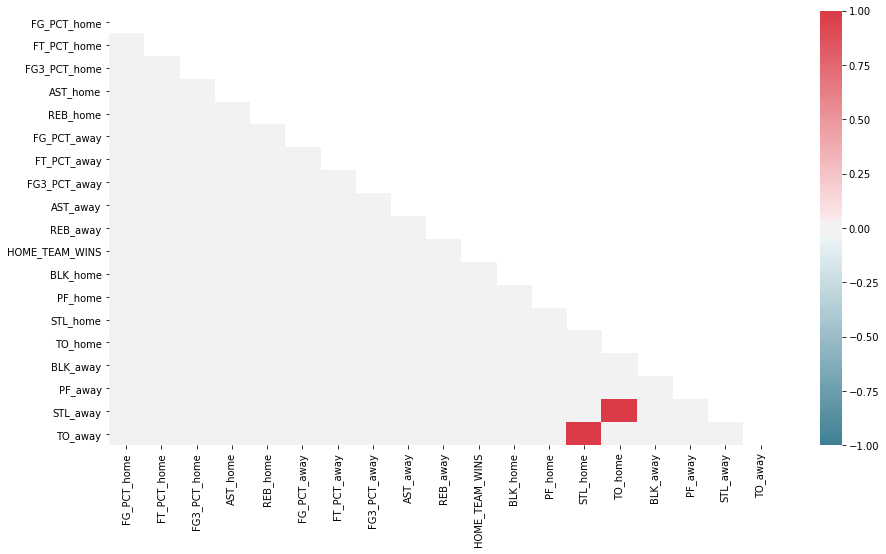

In [110]:
plt.figure(figsize = (15, 8))
sns.heatmap(abs(data.drop('SEASON',axis=1).corr())> 0.70, 
            mask=np.triu(np.ones_like(data.drop('SEASON',axis=1).corr(),dtype=np.bool)),
            cmap = sns.diverging_palette(220,10,as_cmap=True),
           vmax=1,vmin=-1,center=0);

Steals and Turnovers are expected to be correlated with each other. If a team makes a steal, the opposing team will be marked with a turnover.

# Normalize Data

In [111]:
# normalize training data
X_train = X_train.apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)
X_train.head()

# normalize testing data
X_test = X_test.apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)
X_test.head()

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,BLK_home,PF_home,STL_home,TO_home,BLK_away,PF_away,STL_away,TO_away
0,0.23352,0.83333,0.23029,0.34375,0.52381,0.25683,0.58319,0.22526,0.33333,0.89474,0.40000,0.41379,0.38889,0.26923,0.42857,0.04000,0.38889,0.48148
1,0.28297,0.72167,0.50000,0.40625,0.33333,0.54098,0.56217,0.31399,0.53333,0.68421,0.15000,0.55172,0.33333,0.38462,0.57143,0.48000,0.44444,0.44444
50,0.24725,0.77333,0.38174,0.28125,0.52381,0.62842,0.41681,0.45222,0.46667,0.78947,0.20000,0.58621,0.66667,0.46154,0.42857,0.40000,0.44444,0.51852
70,0.40934,0.67667,0.62448,0.31250,0.69048,0.33060,0.63923,0.46587,0.26667,0.71053,0.15000,0.75862,0.22222,0.61538,0.78571,0.72000,0.38889,0.44444
94,0.51923,0.66667,0.34855,0.46875,0.47619,0.51093,0.59194,0.27645,0.63333,0.65789,0.15000,0.62069,0.44444,0.50000,0.28571,0.08000,0.61111,0.29630


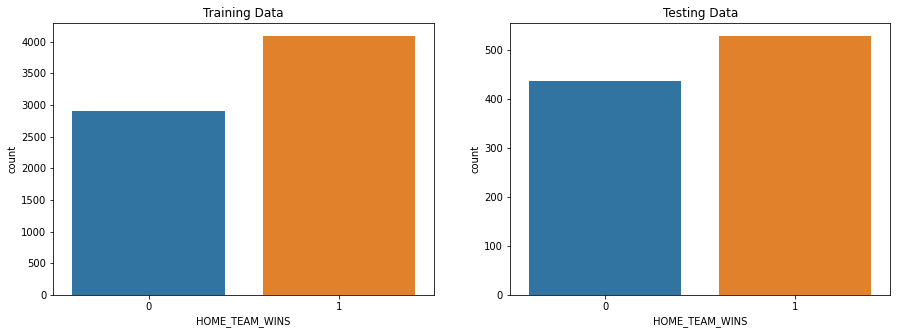

In [112]:
fig,ax =plt.subplots(1,2,figsize=(15,5))
# plt.subplots_adjust(hspace=0.4, wspace=1)
sns.countplot(x='HOME_TEAM_WINS',data=pd.DataFrame(y_train), ax=ax[0]).set_title('Training Data')
sns.countplot(x='HOME_TEAM_WINS',data=pd.DataFrame(y_test), ax=ax[1]).set_title('Testing Data')
fig.show()

# Logistic Regression

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. The model outputs the probability (a number between 0 and 1) for a given dependent value and classifies the value as either binary number 0 or 1.

In [113]:
# logistic regression classifier
logmodel = LogisticRegression()
# fit the model according to the given training data: features and labels
logmodel.fit(X_train,y_train)

# predict class labels for samples in X_train
y_hat_train = logmodel.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = logmodel.predict(X_test)

# roc curve - auc train
train_fpr_logmodel, train_tpr_logmodel, train_thresholds_logmodel = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_logmodel, test_tpr_logmodel, test_thresholds_logmodel = roc_curve(y_test, y_hat_test)

# append classification results
logmodel_results = [logmodel.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = pd.DataFrame([logmodel_results])

In [114]:
# actual probability that a data point belongs to a given class
logmodel.predict_proba(X_test)

array([[0.93060766, 0.06939234],
       [0.98355375, 0.01644625],
       [0.99672616, 0.00327384],
       ...,
       [0.86525123, 0.13474877],
       [0.95057328, 0.04942672],
       [0.34131034, 0.65868966]])

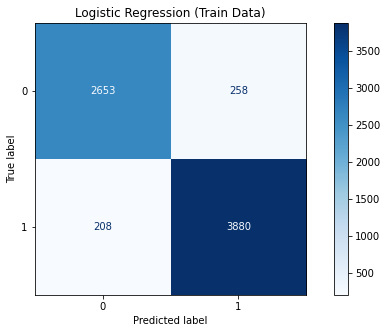

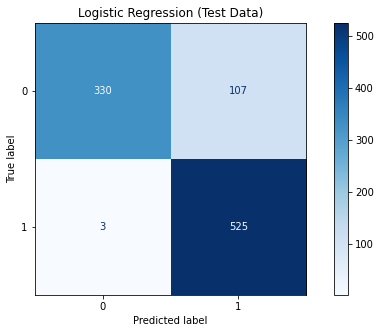

In [115]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(logmodel, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('Logistic Regression (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(logmodel, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('Logistic Regression (Test Data)')
plt.show();

In [116]:
# evaluation metrics for train data
print_metrics_test(y_train,logmodel.predict(X_train),train_fpr_logmodel,train_tpr_logmodel,'Training Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,logmodel.predict(X_test),test_fpr_logmodel,test_tpr_logmodel,'Test Data')

Training Data
-------------------------
Precision Score: 0.9376510391493476
Recall Score: 0.949119373776908
Accuracy Score: 0.9334190598656951
F1 Score: 0.9433503525407245
AUC: 0.9302450183896565


Test Data
-------------------------
Precision Score: 0.8306962025316456
Recall Score: 0.9943181818181818
Accuracy Score: 0.8860103626943006
F1 Score: 0.9051724137931034
AUC: 0.874733461618473


# Decision Trees

A decision tree is one of the supervised machine learning algorithms, this algorithm can be used for regression and classification problems — yet, is mostly used for classification problems. A decision tree follows a set of if-else conditions to visualize the data and classify it according to the conditions.

## GridSearchCV for Decision Trees

In [117]:
clf = DecisionTreeClassifier(criterion='entropy',
                                 max_depth=None,
                                 min_samples_leaf=5,
                                 min_samples_split=10)

In [118]:
# dt_param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 2, 3, 4, 5, 6],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 3, 4, 5, 6]
# }

# # Instantiate GridSearchCV
# clf = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# print("Best Parameter Combination Found During Grid Search:")
# clf.best_params_

# # output
# # {'criterion': 'entropy',
# #  'max_depth': None,
# #  'min_samples_leaf': 5,
# #  'min_samples_split': 10}

In [119]:
# Instantiate GridSearchCV
clf = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
clf.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = clf.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = clf.predict(X_test)

# roc curve - auc train
train_fpr_clf, train_tpr_clf, train_thresholds_clf = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_clf, test_tpr_clf, test_thresholds_clf = roc_curve(y_test, y_hat_test)

# append classification results
clf_results = [clf.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([clf_results])

In [120]:
print("Best Parameter Combination Found During Grid Search:")
clf.best_params_

Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 10}

In [ ]:
## Decision Tree Visual
# fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
# tree.plot_tree(clf,
#                feature_names = final_data.columns, 
#                class_names=np.unique(y).astype('str'),
#                filled = True)
# plt.show()

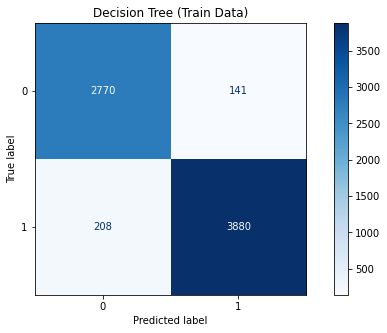

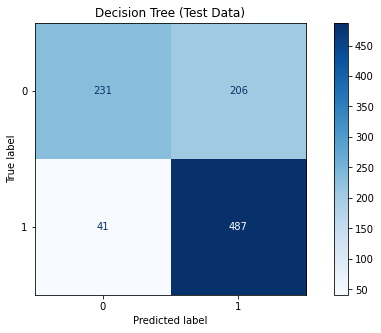

In [121]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(clf, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('Decision Tree (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('Decision Tree (Test Data)')
plt.show();

In [122]:
# evaluation metrics for train data
print_metrics_test(y_train,clf.predict(X_train),train_fpr_clf,train_tpr_clf,'Training Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,clf.predict(X_test),test_fpr_clf,test_tpr_clf,'Test Data')

Training Data
-------------------------
Precision Score: 0.9649340959960209
Recall Score: 0.949119373776908
Accuracy Score: 0.9501357336762395
F1 Score: 0.9569614009125663
AUC: 0.9503412052670182


Test Data
-------------------------
Precision Score: 0.7027417027417028
Recall Score: 0.9223484848484849
Accuracy Score: 0.7440414507772021
F1 Score: 0.7977067977067979
AUC: 0.7254763019208099


# Random Forest

The Random Forest algorithm is a supervised learning algorithm that can be used both for classification and regression tasks. The random forest algorithm is an ensemble (algorithm that makes use of more than one model to make a prediction) of decision trees. 

An ensemble of trees using the same dataset will give us the same tree. To create high variance among all trees, we use bagging and subspace sampling method techniques increasing variability with each technique.
* Bootstrap Aggregation (Bagging) - train trees using different samples of data by sampling with replacement
* Subspace Sampling Method - randomly select subset of features to use as predictors for each node when training a decision tree, instead of using all predictors available at each node

In [123]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth= 5)

# Fit the classifier
random_forest.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = random_forest.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = random_forest.predict(X_test)

# roc curve - auc train
train_fpr_random_forest, train_tpr_random_forest, train_thresholds_random_forest = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_random_forest, test_tpr_random_forest, test_thresholds_random_forest = roc_curve(y_test, y_hat_test)

# append classification results
random_forest_results = [random_forest.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([random_forest_results])

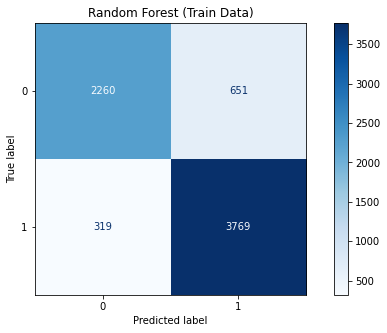

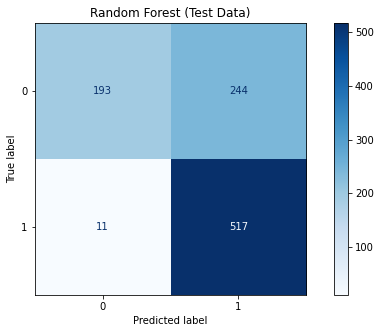

In [124]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(random_forest, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('Random Forest (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(random_forest, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('Random Forest (Test Data)')
plt.show();

In [125]:
# evaluation metrics for train data
print_metrics_test(y_train,random_forest.predict(X_train),train_fpr_random_forest,train_tpr_random_forest,'Training Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,random_forest.predict(X_test),test_fpr_random_forest,test_tpr_random_forest,'Test Data')

Training Data
-------------------------
Precision Score: 0.8527149321266968
Recall Score: 0.9219667318982387
Accuracy Score: 0.8614087726818117
F1 Score: 0.885989656793606
AUC: 0.8491661210161067


Test Data
-------------------------
Precision Score: 0.6793692509855453
Recall Score: 0.9791666666666666
Accuracy Score: 0.7357512953367875
F1 Score: 0.8021722265321954
AUC: 0.7104071319603356


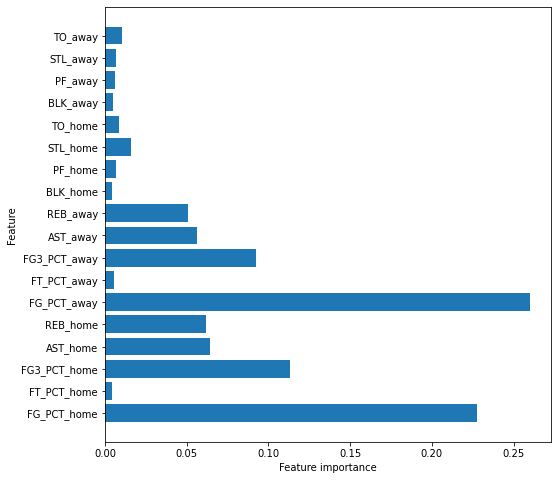

In [126]:
plot_feature_importances(random_forest,X_train)

# K-Nearest Neighbors

K-Nearest Neighbors is a supervised learning algorithm that can be used for both Classification and Regression tasks. A value is assigned a class which is most common among its K nearest neighbors, K being the number of neighbors. If K = 3, a value looks at the nearest 3 neighbors by calculating the distance between the value and class values.

In [127]:
# function to figure out the best number of for k-neighbors
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [128]:
find_best_k(X_train, y_train, X_test, y_test)

Best Value for k: 25
F1-Score: 0.859038142620232


In [129]:
# Instantiate KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=25, metric='euclidean')

# Fit the classifier
knn.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = knn.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = knn.predict(X_test)

# roc curve - auc train
train_fpr_knn, train_tpr_knn, train_thresholds_knn = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_knn, test_tpr_knn, test_thresholds_knn = roc_curve(y_test, y_hat_test)

# append classification results
knn_results = [knn.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([knn_results])

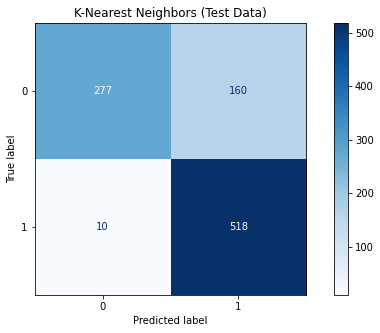

In [130]:
# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(knn, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('K-Nearest Neighbors (Test Data)')
plt.show();

In [131]:
# evaluation metrics for test data
print_metrics_test(y_test,knn.predict(X_test),test_fpr_knn,test_tpr_knn,'Training Data')

Training Data
-------------------------
Precision Score: 0.7640117994100295
Recall Score: 0.9810606060606061
Accuracy Score: 0.8238341968911918
F1 Score: 0.859038142620232
AUC: 0.807463941474239


# XGBoost

In [132]:
XGB = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
# Fit the classifier
XGB.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = XGB.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = XGB.predict(X_test)

# roc curve - auc train
train_fpr_XGB, train_tpr_XGB, train_thresholds_XGB = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_XGB, test_tpr_XGB, test_thresholds_XGB = roc_curve(y_test, y_hat_test)

XGB_results = [XGB.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([XGB_results])

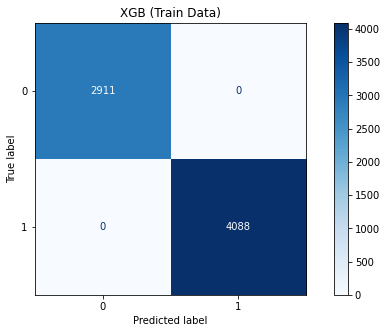

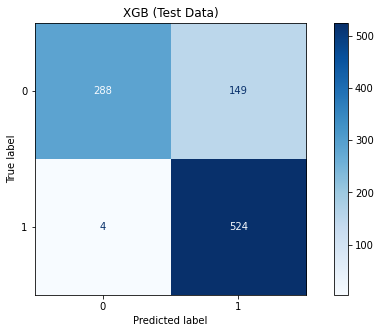

In [133]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(XGB, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('XGB (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(XGB, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('XGB (Test Data)')
plt.show();

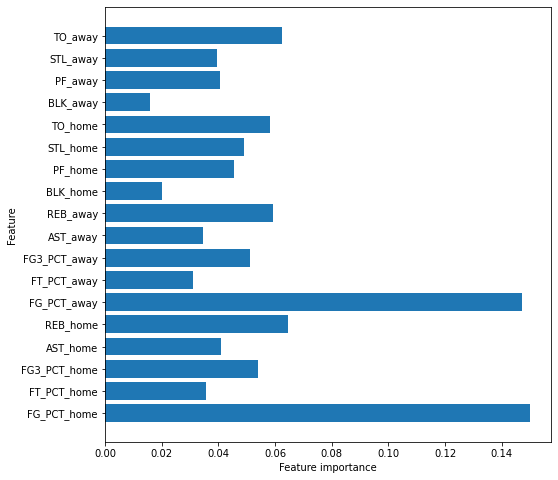

In [134]:
plot_feature_importances(XGB,X_train)

In [135]:
# evaluation metrics for train data
print_metrics_test(y_train,XGB.predict(X_train),train_fpr_XGB,train_tpr_XGB,'Training Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,XGB.predict(X_test),test_fpr_XGB,test_tpr_XGB,'Test Data')

Training Data
-------------------------
Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0
AUC: 1.0


Test Data
-------------------------
Precision Score: 0.7786032689450223
Recall Score: 0.9924242424242424
Accuracy Score: 0.8414507772020725
F1 Score: 0.8726061615320565
AUC: 0.8257315720130365


# Gradient Boosting

In [136]:
gboost = GradientBoostingClassifier()

# predict class labels for samples in X_test
gboost.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = gboost.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = gboost.predict(X_test)

# roc curve - auc train
train_fpr_gboost, train_tpr_gboost, train_thresholds_gboost = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_gboost, test_tpr_gboost, test_thresholds_gboost = roc_curve(y_test, y_hat_test)

# append classification results
gboost_results = [gboost.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([gboost_results])

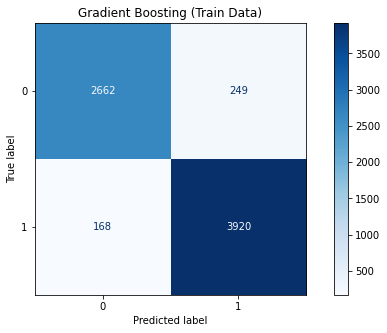

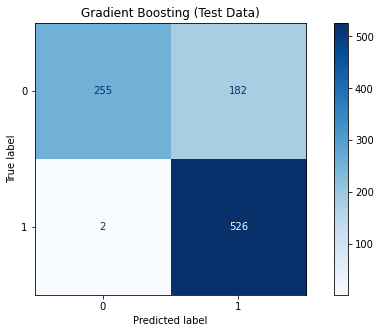

In [137]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(gboost, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('Gradient Boosting (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(gboost, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('Gradient Boosting (Test Data)')
plt.show();

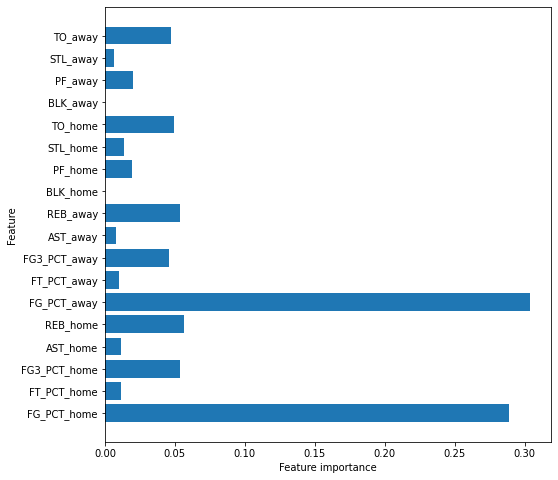

In [138]:
plot_feature_importances(gboost,X_train)

In [139]:
# evaluation metrics for train data
print_metrics_test(y_train,gboost.predict(X_train),train_fpr_gboost,train_tpr_gboost,'Training Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,gboost.predict(X_test),test_fpr_gboost,test_tpr_gboost,'Test Data')

Training Data
-------------------------
Precision Score: 0.9402734468697529
Recall Score: 0.958904109589041
Accuracy Score: 0.9404200600085727
F1 Score: 0.9494973961487222
AUC: 0.9366832468247507


Test Data
-------------------------
Precision Score: 0.7429378531073446
Recall Score: 0.9962121212121212
Accuracy Score: 0.8093264248704664
F1 Score: 0.8511326860841424
AUC: 0.7898680743360377


# LinearSVC

In [140]:
# lclf = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
lclf = svm.SVC()

# predict class labels for samples in X_test
lclf.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = lclf.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = lclf.predict(X_test)

# roc curve - auc train
train_fpr_lclf, train_tpr_lclf, train_thresholds_lclf = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_lclf, test_tpr_lclf, test_thresholds_lclf = roc_curve(y_test, y_hat_test)

# append classification results
lclf_results = [lclf.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([lclf_results])

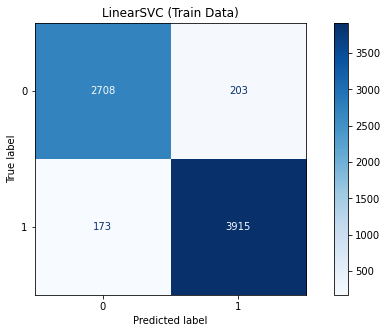

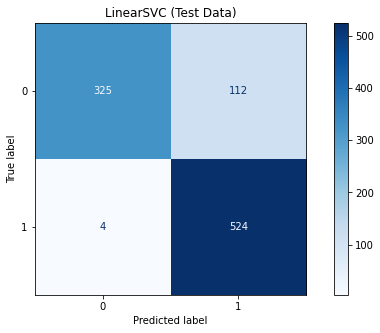

In [145]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(lclf, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('LinearSVC (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(lclf, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('LinearSVC (Test Data)')
plt.savefig('images/LinearSVC_confusion_matrix_result.png')
plt.show();

In [142]:
# evaluation metrics for train data
print_metrics_test(y_train,lclf.predict(X_train),train_fpr_lclf,train_tpr_lclf,'Training Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,lclf.predict(X_test),test_fpr_lclf,test_tpr_lclf,'Test Data')

Training Data
-------------------------
Precision Score: 0.9507042253521126
Recall Score: 0.9576810176125244
Accuracy Score: 0.9462780397199599
F1 Score: 0.9541798683889836
AUC: 0.9439727657626346


Test Data
-------------------------
Precision Score: 0.8238993710691824
Recall Score: 0.9924242424242424
Accuracy Score: 0.8797927461139896
F1 Score: 0.9003436426116839
AUC: 0.8680656681228763


# Model Evaluation

In [143]:
alg = alg.rename({0:'model',1:'accuracy_score', 2:'roc_auc_score'},axis=1).sort_values(by='accuracy_score', ascending=False)
alg

,model,accuracy_score,roc_auc_score
0,<class 'sklearn.linear_model._logistic.Logisti...,0.88601,0.87473
0,<class 'sklearn.svm._classes.SVC'>,0.87979,0.86807
0,<class 'xgboost.sklearn.XGBClassifier'>,0.84145,0.82573
0,<class 'sklearn.neighbors._classification.KNei...,0.82383,0.80746
0,<class 'sklearn.ensemble._gb.GradientBoostingC...,0.80933,0.78987
0,<class 'sklearn.model_selection._search.GridSe...,0.74404,0.72548
0,<class 'sklearn.ensemble._forest.RandomForestC...,0.73575,0.71041


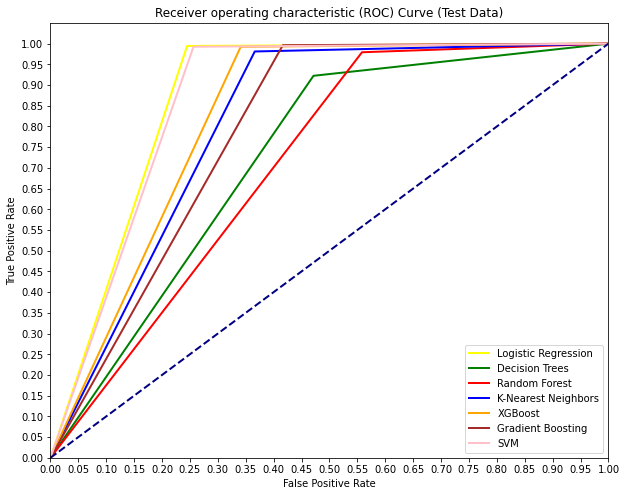

In [146]:
# model plots
plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr_logmodel, test_tpr_logmodel, color='yellow',lw=lw, label='Logistic Regression')
plt.plot(test_fpr_clf, test_tpr_clf, color='green',lw=lw, label='Decision Trees')
plt.plot(test_fpr_random_forest, test_tpr_random_forest, color='red',lw=lw, label='Random Forest')
plt.plot(test_fpr_knn, test_tpr_knn, color='blue',lw=lw, label='K-Nearest Neighbors')
plt.plot(test_fpr_XGB, test_tpr_XGB, color='orange',lw=lw, label='XGBoost')
plt.plot(test_fpr_gboost, test_tpr_gboost, color='brown',lw=lw, label='Gradient Boosting')
plt.plot(test_fpr_lclf, test_tpr_lclf, color='pink',lw=lw, label='SVM')

# Formatting
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve (Test Data)')
plt.legend(loc="lower right")
plt.savefig('images/ROC_curve.png')
plt.show()

# Conclusion

Based on the accuracy of all the models, the one with the highest accuracy is Logistic Regression with an accuracy of 82% based on test data. We trained the data using 2004-2018 historical data and tested the first 66 nba games of the 2019 season.

When it comes to NBA basketball games, there is something called an upset which mean there can be cases where a team can do really well but can still lose the game and upsets do happen frequently. The model does not take care of upsets which can be difficult but with an accuracy of 82%, I would consider that a fair accuracy rate.

## Future Iterations

I eventually want to predict NBA games based on the spread. When it comes to spread, different features will be needed to predict games. Because the test data I provided already has the game stats, in a real time basketball game, the performance and stats of the game has not been played out yet. The data will need to be based on only the historical data.